In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import time

In [ ]:
mnist_transforms = transforms.Compose(
                                      [transforms.ToTensor(),
                                       transforms.Normalize(mean=0.5, std=0.5),]
                                      )
data = datasets.MNIST(root='/data/MNIST', download=True, transform=mnist_transforms)
mnist_dataloader = DataLoader(data, batch_size=128, shuffle=True, num_workers=4) 

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1=nn.Sequential(torch.nn.ConvTranspose2d(100, 64, 10),nn.ReLU(0.2),nn.BatchNorm2d(64))
    self.fc2=nn.Sequential(torch.nn.ConvTranspose2d(64, 32, 10),nn.ReLU(0.2),nn.BatchNorm2d(32))
    self.fc3=nn.Sequential(torch.nn.ConvTranspose2d(32, 32, 5),nn.ReLU(0.2),nn.BatchNorm2d(32))
    self.fc4=nn.Sequential(torch.nn.ConvTranspose2d(32, 1, 6),nn.Tanh())
  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,16,8),nn.LeakyReLU(0.2),nn.BatchNorm2d(16),nn.Conv2d(16, 32, 8),nn.LeakyReLU(0.2),nn.BatchNorm2d(32))    
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 8),nn.LeakyReLU(0.2),nn.BatchNorm2d(32),nn.Conv2d(32, 1, 7),nn.Tanh())    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)      
        return x 

In [ ]:
import pytorch_lightning as pl

class GAN(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.generator = Generator()
    self.discriminator = Discriminator()
    self.test_noises = torch.randn(100,100,1,1, device=device)
    self.test_progression = []

  def forward(self, z):
    return self.generator(z)

  def generator_step(self, x):
    z = torch.randn(x.shape[0], 100,1, 1, device=device)
    generated_imgs = self(z)
    d_output = torch.squeeze(self.discriminator(generated_imgs))
    g_loss = nn.BCEWithLogitsLoss()(d_output,torch.ones(x.shape[0], device=device))
    return g_loss

  def discriminator_step(self, x):
    d_output = torch.squeeze(self.discriminator(x))

    loss_real = nn.BCEWithLogitsLoss()(d_output,torch.ones(x.shape[0], device=device))
    z = torch.randn(x.shape[0], 100, 1,1, device=device)
    generated_imgs = self(z)
    d_output = torch.squeeze(self.discriminator(generated_imgs))
    loss_fake = nn.BCEWithLogitsLoss()(d_output,
                             torch.zeros(x.shape[0], device=device))

    return loss_real + loss_fake

  def training_step(self, batch, batch_idx, optimizer_idx):
    X, _ = batch
    
    if optimizer_idx == 0:
      loss = self.generator_step(X)
    
    if optimizer_idx == 1:
      loss = self.discriminator_step(X)

    return loss

  def configure_optimizers(self):
    g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
    return [g_optimizer, d_optimizer], []

  def training_epoch_end(self, training_step_outputs):
    epoch_test_images = self(self.test_noises)
    self.test_progression.append(epoch_test_images)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start = time.time()
model = GAN()
trainer = pl.Trainer(max_epochs=100, gpus=1)
trainer.fit(model, mnist_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 871 K 
1 | discriminator | Discriminator | 101 K 
------------------------------------------------
973 K     Trainable params
0         Non-trainable params
973 K     Total params
3.892     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
total_time = (time.time() - start)//60
print("Total time taken is : ",total_time," min")

Total time taken is :  28.0  min


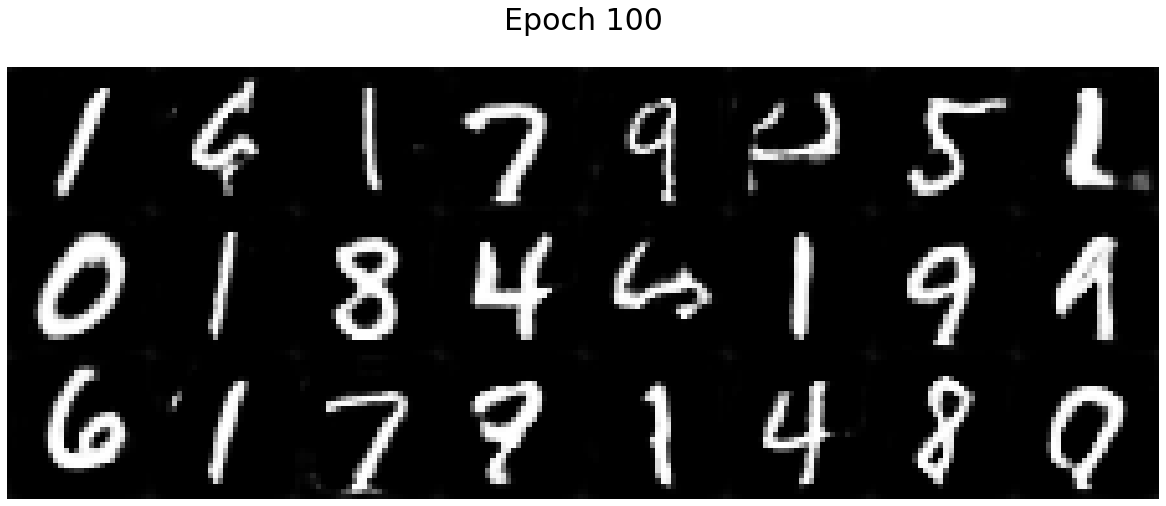

In [ ]:
import numpy as np
from matplotlib import pyplot as plt, gridspec

# Convert images from torch tensor to numpy array
images = [i.detach().cpu().numpy() for i in model.test_progression]

epoch_to_plot = 100
nrow = 3
ncol = 8

# randomly select 10 images for plotting
indexes = np.random.choice(range(100), nrow*ncol, replace=False)

fig = plt.figure(figsize=((ncol+1)*2, (nrow+1)*2)) 
fig.suptitle('Epoch {}'.format(epoch_to_plot), fontsize=30)

gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

for i in range(nrow):
    for j in range(ncol):
        idx = i*ncol + j
        img = np.reshape(images[epoch_to_plot-1][indexes[idx]], (28,28))
        ax = plt.subplot(gs[i,j])
        ax.imshow(img, cmap='gray')
        ax.axis('off')